# 5002 Assignment 5

ZHANG Juntao - 20908272

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime 
import requests
import matplotlib.dates as mdates
from matplotlib.animation import FuncAnimation
from matplotlib import animation
from bs4 import BeautifulSoup
from PIL import Image

## 1. COVID in Hong Kong

### a)

In [2]:
# load data
df = pd.read_csv('Desktop/latest_situation_of_reported_cases_covid_19_eng.csv')
columns = ['As of date', 
           'Number of confirmed cases',
           'Number of cases tested positive for SARS-CoV-2 virus by nucleic acid tests',
           'Number of cases tested positive for SARS-CoV-2 virus by rapid antigen tests'
          ]
df = df[columns]
df.columns = ['date', 'cases', 'NCT', 'RAT']

# get the amount of daily confirmed cases
boundary = df[df['date'].str.contains('01/01/2022')].index[0]
part1 = df['cases'].loc[:boundary-1].values
p2 = df[['NCT', 'RAT']].loc[boundary:].fillna(0)
part2 = p2.NCT.values + p2.RAT.values
case = np.concatenate((part1, part2), axis=None)
daily_cases = np.array([i - j for i, j in zip(case[1:], case)])
daily_cases = np.concatenate(([0], daily_cases), axis=0)

df_new = pd.DataFrame({'date': df.date.values,
                       'cases': daily_cases})

# get split points of three years
node1 = df_new[df_new['date'].str.contains('2020')].index[-1]
node2 = df_new[df_new['date'].str.contains('2021')].index[-1]
df_new = df_new.drop(index=df_new[df_new['date'].str.contains('29/02/2020')].index[0])

# get needed data for plotting
SMA = [np.mean(df_new['cases'].values[i:i+7]) for i in range(len(df_new['cases'])-7)]
df_2020 = df_new.loc[:node1]
df_2021 = df_new.loc[node1+1:node2]
df_2021.index = [i for i in range(len(df_2021))]
df_2022 = df_new.loc[node2+1:]
df_2022.index = [i for i in range(len(df_2022))]

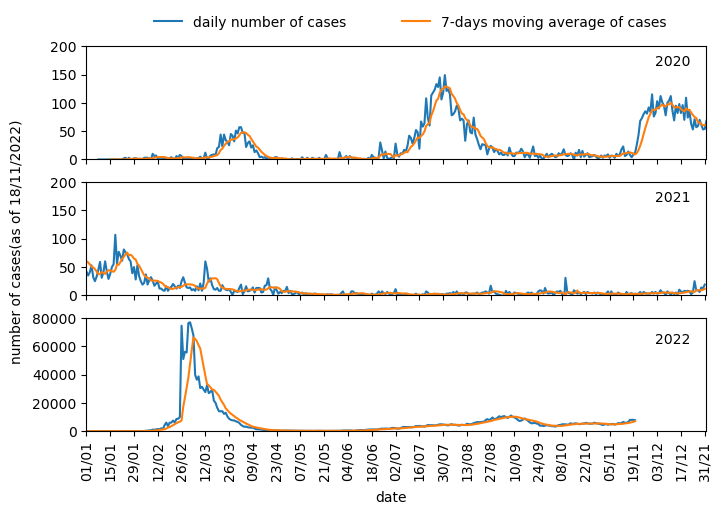

In [3]:
xlabels=['01/01','15/01','29/01','12/02','26/02','12/03','26/03','09/04','23/04',
         '07/05','21/05','04/06','18/06','02/07','16/07','30/07','13/08','27/08',
         '10/09','24/09','08/10','22/10','05/11','19/11','03/12','17/12','31/21']
xticks = np.linspace(0, 364, len(xlabels))

plt.figure(figsize=(8,5))
ax1 = plt.subplot(311)
ax1.plot(df_2020.index+7, df_2020.cases.values, label='daily number of cases')
ax1.plot(np.arange(14, 365), SMA[:node1-7], label='7-days moving average of cases')
ax1.text(335,165,"2020")
ax1.set_xlim(0,365)
ax1.set_ylim(0,200)
ax1.set_xticks(ticks=xticks,labels=[])
lines, labels=ax1.get_legend_handles_labels()
legend1=ax1.legend([lines[1]], [labels[1]],loc=(0.5,1.1), frameon=False)
legend2=ax1.legend([lines[0]], [labels[0]],loc=(0.1,1.1), frameon=False)
ax1.add_artist(legend1)

ax2 = plt.subplot(312)
ax2.plot(df_2021.index, df_2021.cases.values)
ax2.plot(np.arange(365), SMA[node1-7:node2-7])
ax2.text(335,165,"2021")
ax2.set_xlim(0,365)
ax2.set_ylim(0,200)
ax2.set_xticks(ticks=xticks,labels=[])

ax3 = plt.subplot(313)
ax3.plot(df_2022.index, df_2022.cases.values)
ax3.plot(np.arange(324), SMA[node2-7:])
ax3.text(335,62000,"2022")
ax3.set_xlim(0,365)
ax3.set_ylim(0,80000)
ax3.set_xticks(xticks)
ax3.set_xticklabels(xlabels, rotation='vertical')
ax3.text(170, -50000, s='date')
ax3.text(-45, 50000, s='number of cases(as of 18/11/2022)',rotation='vertical')
# plt.savefig('Q1_a.png')
plt.show()

### b)

In [4]:
df2 = pd.read_csv('Desktop/enhanced_sur_covid_19_eng.csv')
df2 = df2[['Report date', 'Classification*']]
df2.columns = ['date', 'category']

dic = {'Epidemiologically linked with imported case': 'import',
       'Imported case': 'import',
       'Epidemiologically linked with local case': 'local',
       'Epidemiologically linked with possibly local case': 'local',
       'Local case': 'local',
       'Locally acquired case': 'local',
       'Possibly local case': 'local'}

df2['category'].replace(dic, inplace=True)
df2['date'] = pd.to_datetime(df2['date'], format="%d/%m/%Y")

df2['amount'] = 0
df2.loc[df2.category=='import', ['amount']]=1
import_case = df2.groupby('date').agg('sum').values.ravel()
df2['amount'] = 0
df2.loc[df2.category=='local', ['amount']]=1
local_case = df2.groupby('date').agg('sum').values.ravel()

df2_new = pd.DataFrame({'date': df2.groupby('date').agg('sum').index.values,
                        'local': local_case,
                        'imported': import_case})

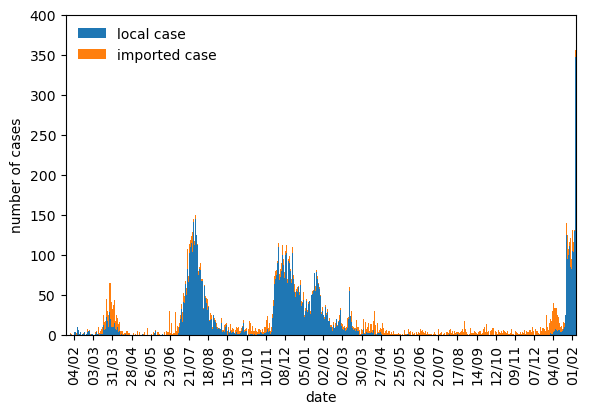

In [5]:
fig = plt.figure(figsize=(6,4)) # dpi=150
ax = fig.add_axes([0.1,0.15,0.85,0.8])

ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=28))
ax.xaxis.set_tick_params(rotation = 90)

ax.bar(df2_new.date, df2_new.local, width=1, label='local case')
ax.bar(df2_new.date, df2_new.imported,width=1, bottom=df2_new.local, label='imported case')

ax.set_xlim([datetime.date(2020, 1, 23), datetime.date(2022, 2, 6)])
ax.set_ylim(0, 400)
ax.set_xlabel('date')
ax.set_ylabel('number of cases')
ax.legend(loc='upper left',frameon=False)
# plt.savefig('Q1_b.png')
plt.show()

### c)

In [6]:
df3 = pd.read_csv('Desktop/enhanced_sur_covid_19_eng.csv')
df3 = df3[['Report date', 'Gender', 'Age']]
df3.columns = ['date', 'gender', 'age']
df3.loc[df3.age=='<1', ['age']]=0
df3 = df3.drop(index=df3.loc[df3.age=='Pending'].index)

male_ages = df3.loc[df3.gender=='M', 'age'].values.astype(int)
female_ages = df3.loc[df3.gender=='F', 'age'].values.astype(int)

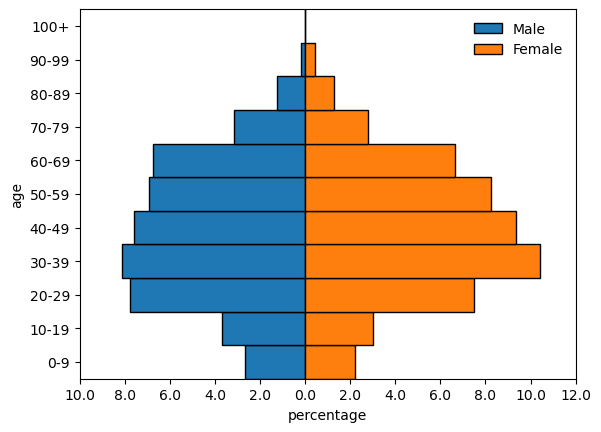

In [7]:
bins=[10*i for i in range(12)]
f = plt.hist(female_ages, bins, histtype='bar',density=True, rwidth=1.5,edgecolor='k')
m = plt.hist(male_ages, bins, histtype='bar',density=True, rwidth=1.5,edgecolor='k')
plt.close()

coef_m = len(male_ages)/(len(male_ages)+len(female_ages))
coef_f = 1-coef_m
y = [5+10*i for i in range(11)]

fig=plt.figure()
ax=fig.add_subplot(111)
ax.barh(y,-m[0]*coef_m, height=10, edgecolor='k', label='Male')
ax.barh(y, f[0]*coef_f, height=10, edgecolor='k', label='Female')


xlabels = ['10.0','8.0','6.0','4.0','2.0','0.0','2.0','4.0','6.0','8.0','10.0','12.0']
ylabels = ['0-9','10-19','20-29','30-39','40-49','50-59','60-69','70-79','80-89','90-99','100+']
ax.set_xlim(-0.01,0.012)
ax.set_ylim(0,110)
ax.set_xticks(ticks=np.linspace(-0.01,0.012,12),labels=xlabels)
ax.set_yticks(ticks=np.linspace(5,105,11),labels=ylabels)
ax.set_xlabel('percentage')
ax.set_ylabel('age')
ax.legend(frameon=False)
# plt.savefig('Q1_c.png')
plt.show()

## 2. Typhoons in Hong Kong

### a)

In [8]:
def typhoon_data(url):
    r = requests.get(url)
    html_contents = r.text
    html_soup = BeautifulSoup(html_contents, 'html.parser')
    table = html_soup.find(name= 'table', class_='data_table')
    # get heads - first two rows
    r1 = table.find_all('tr')[0]
    r2 = table.find_all('tr')[1]
    id_r1, id_r2 = [], []
    for column in r1.find_all('th')[1:]:
        for j in range(int(column['colspan'])):
            id_r1.append(column['id'])
    for column in r2.find_all('th'):
        id_r2.append(column['id'])  
        
    # get all data
    values = []
    for row in table.find_all('tr')[2:]:
        value = []
        for col in row.find_all('td'):
            value.append(col.text.strip())
        if value:
            values.append(value)
    
    values = np.array(values)
    df = pd.DataFrame(values[:,1:], 
                      index=values[:,0].tolist(), 
                      columns=[id_r1, id_r2])
    df.columns = [['nearest','','','','min','','max','',''],['  date','year','direction','distance',
              'hourly','inst','category','max_sustained','max_min']]
    df.index.names = ['name']
    # df.style.set_properties(**{'text-align': 'left'})
    #.set_table_styles([dict(selector = 'th', props=[('text-align', 'left')])])
    # display(df)
    return df

In [9]:
url = 'https://www.weather.gov.hk/en/informtc/historical_tc/metinfo_wind.htm'
typhoon_data(url)

nearest                             min              max  \
            date  year direction distance hourly   inst  category   
name                                                                
-           18/7  1946         S       70  985.7      -         &   
Gloria      22/9  1957        SW       55  986.2  984.3  Severe T   
Mary         9/6  1960       WNW       10  974.3  973.8         T   
Alice       19/5  1961         -        0  981.6  981.1         T   
Wanda        1/9  1962       SSW       20  955.1  953.2   Super T   
Ruby         5/9  1964        SW       30  971.0  968.2   Super T   
Dot        13/10  1964         E       35  978.9  977.3         T   
Shirley     21/8  1968         -        0  968.7  968.6         T   
Rose        17/8  1971       WSW       20  984.5  982.8   Super T   
Elsie      14/10  1975         S       50  996.4  996.2         T   
Hope         2/8  1979       NNW       10  961.8  961.6   Super T   
Ellen        9/9  1983        SW       45  983.9  983.1  Severe T   
York        16/9  1999       SSW       20  976.8  976.1         T   
Vicente     24/7  2012        SW      100  986.3  986.0  Severe T   
Hato        23/8  2017       SSW       60  986.7  986.3   Super T   
Mangkhut    16/9  2018       SSW      100  977.6  977.0   Super T   

                                
         max_sustained max_min  
name                            
-                    &       &  
Gloria             155     980  
Mary               140     970  
Alice              120     980  
Wanda              185     950  
Ruby               195     960  
Dot                145     975  
Shirley            145     965  
Rose               185     960  
Elsie              140     985  
Hope               205     940  
Ellen              165     960  
York               130     965  
Vicente            155     950  
Hato               185     950  
Mangkhut           185     945

### b)

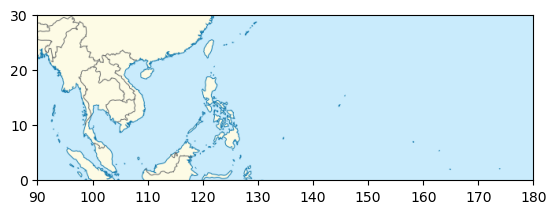

In [10]:
bg = Image.open('Desktop/assignment5_materials/equirectangular_map.png')
width, height = bg.size
left = width*(270/360)
right = width
top = height*(60/180)
bottom = height*(90/180)
bg = bg.crop((left, top, right, bottom))
plt.figure()
plt.imshow(bg ,extent=[90,180,0,30])

In [11]:
def scrape_data(url):
    r = requests.get(url)
    html_contents = r.text
    html_soup = BeautifulSoup(html_contents,'html.parser')
    html_table = html_soup.find_all('table')[-1]
   
    html_headers = []
    for header in html_table.find('tr').find_all('th'):
        html_headers.append(header.text)

    df = pd.DataFrame(columns=html_headers)
    for row in html_table.find_all('tr'):
        values = []
        for col in row.find_all('td'):
            values.append(col.text)
        if values:
            dic = {html_headers[i]: values[i] for i in range(len(values))}
            df.loc[len(df.index)] = dic
   
    df = df[[' ISO_TIME_________', ' HKO LAT', ' HKO LON']]
    df.columns = ['time', 'lat', 'lon']
    df['Time']=0
    df['distance']=0
    hk_lon, hk_lat = 114.17, 22.25
    df.drop(0, axis=0, inplace=True)
    df.reset_index(inplace=True)
    
    for i in range(len(df)):
        if len(df.loc[i,'time']) == 20:
            tmp_date=df.loc[i,'time'][0:11]
        elif len(df.loc[i,'time']) == 9:
            df.loc[i,'time'] = tmp_date + df.loc[i,'time']
        if df.loc[i,'lon'] == ' ':
            continue
        else:
            df.loc[i,'Time']=datetime.datetime.strptime(df.loc[i,'time'],' %Y-%m-%d %H:%M:%S')
            lon, lat = float(df.loc[i,'lon']), float(df.loc[i,'lat'])
            df.loc[i,'distance'] = (hk_lon-lon)**2+(hk_lat-lat)**2
    df.drop(df.loc[df['lon']==' '].index, inplace=True, axis=0)
    df.reset_index(inplace=True)
    df['h']=0
    for i in range(len(df)):
        df.loc[i,'h']=int((df.loc[i,'Time']-df.loc[int(df[['distance']].idxmin()),'Time']).total_seconds()/3600)
        
    return df, np.array(df[['lon','lat','h']]).astype(float)

In [12]:
url1 = 'https://ibtracs.unca.edu/index.php?name=v04r00-2017232N19130'
url2 = 'https://ibtracs.unca.edu/index.php?name=v04r00-2018250N12170'
hato_df, hato_array = scrape_data(url1)
mang_df, mang_array = scrape_data(url2)

In [13]:
fig,ax=plt.subplots(figsize=(12,4))
ln1,=plt.plot([],[],'o',markersize=3, label='Hato')
ln2,=plt.plot([],[],'o',markersize=3, label='Mangkhut')
text=plt.text(90,32,'$h=-215$',fontsize=15)


def initial():
    ax.imshow(bg,extent=[90,180,0,30])
    ax.set_xticks(np.linspace(90,180,7))
    ax.set_yticks(np.linspace(0,30,3))
    ax.grid(visible=True)
    ax.legend(frameon=False,fontsize=15)
    ax.plot([mang_array[0,0]],[mang_array[0,1]],marker='o',c='#ff7f0e',markersize=3)

    
def update(h):
    if not hato_df.loc[hato_df.h==h].empty:
        ix = hato_df.loc[hato_df.h==h].index[0]
        ln1.set_data(hato_array[:ix+1,0], hato_array[:ix+1,1])
        text.set_text(f'$h={h}$')
    if not mang_df.loc[mang_df.h==h].empty:
        ix = mang_df.loc[mang_df.h==h].index[0]      
        ln2.set_data(mang_array[:ix+1,0], mang_array[:ix+1,1])
        text.set_text(f'$h={h}$')
    return ln1, ln2, ax, text

ani = FuncAnimation(fig=fig,
                    func=update,
                    init_func=initial, 
                    frames=np.arange(-215,34),
                    interval=100)
plt.close()
writer = animation.writers['ffmpeg'](fps=10, metadata=dict(artist='Me'), bitrate=1800)
# ani.save('Q2.mp4',writer=writer)